# simSPI tutorial

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import raster_geometry

from simSPI.linear_simulator import noise_utils
from simSPI.linear_simulator import shift_utils
from ioSPI import fourier
from simSPI import multislice
from simSPI import transfer

def plot_image(img, scale, cmap='gray'):
    height, width = img.shape
    plt.figure(figsize=(height*scale, width*scale))
    plt.imshow(img, cmap)
    plt.axis('off')
    plt.show()

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

### noise_utils

In [2]:
#Load micrograph
micrograph_path = 'tests/test_files/micrograph.npz'
micrograph = np.load(micrograph_path)
micrograph = micrograph['arr_0']
(height, width) = micrograph.shape

The Noise class only accepts a gaussian distribution, and 'noise_sigma' is the only parametere which must be provided in the config dict so far.

In [3]:
#Define the Noise that will be used
config = {'noise': True, 'noise_sigma': 1.5, 'noise_distribution': 'gaussian'}
config = AttrDict(config)

#Create Noise
gaussain_noise = noise_utils.Noise(config)

#Apply the gaussian noise to the micrograph
micrograph_with_noise = gaussain_noise.forward(torch.tensor(micrograph))
micrograph_with_noise = micrograph_with_noise.numpy()

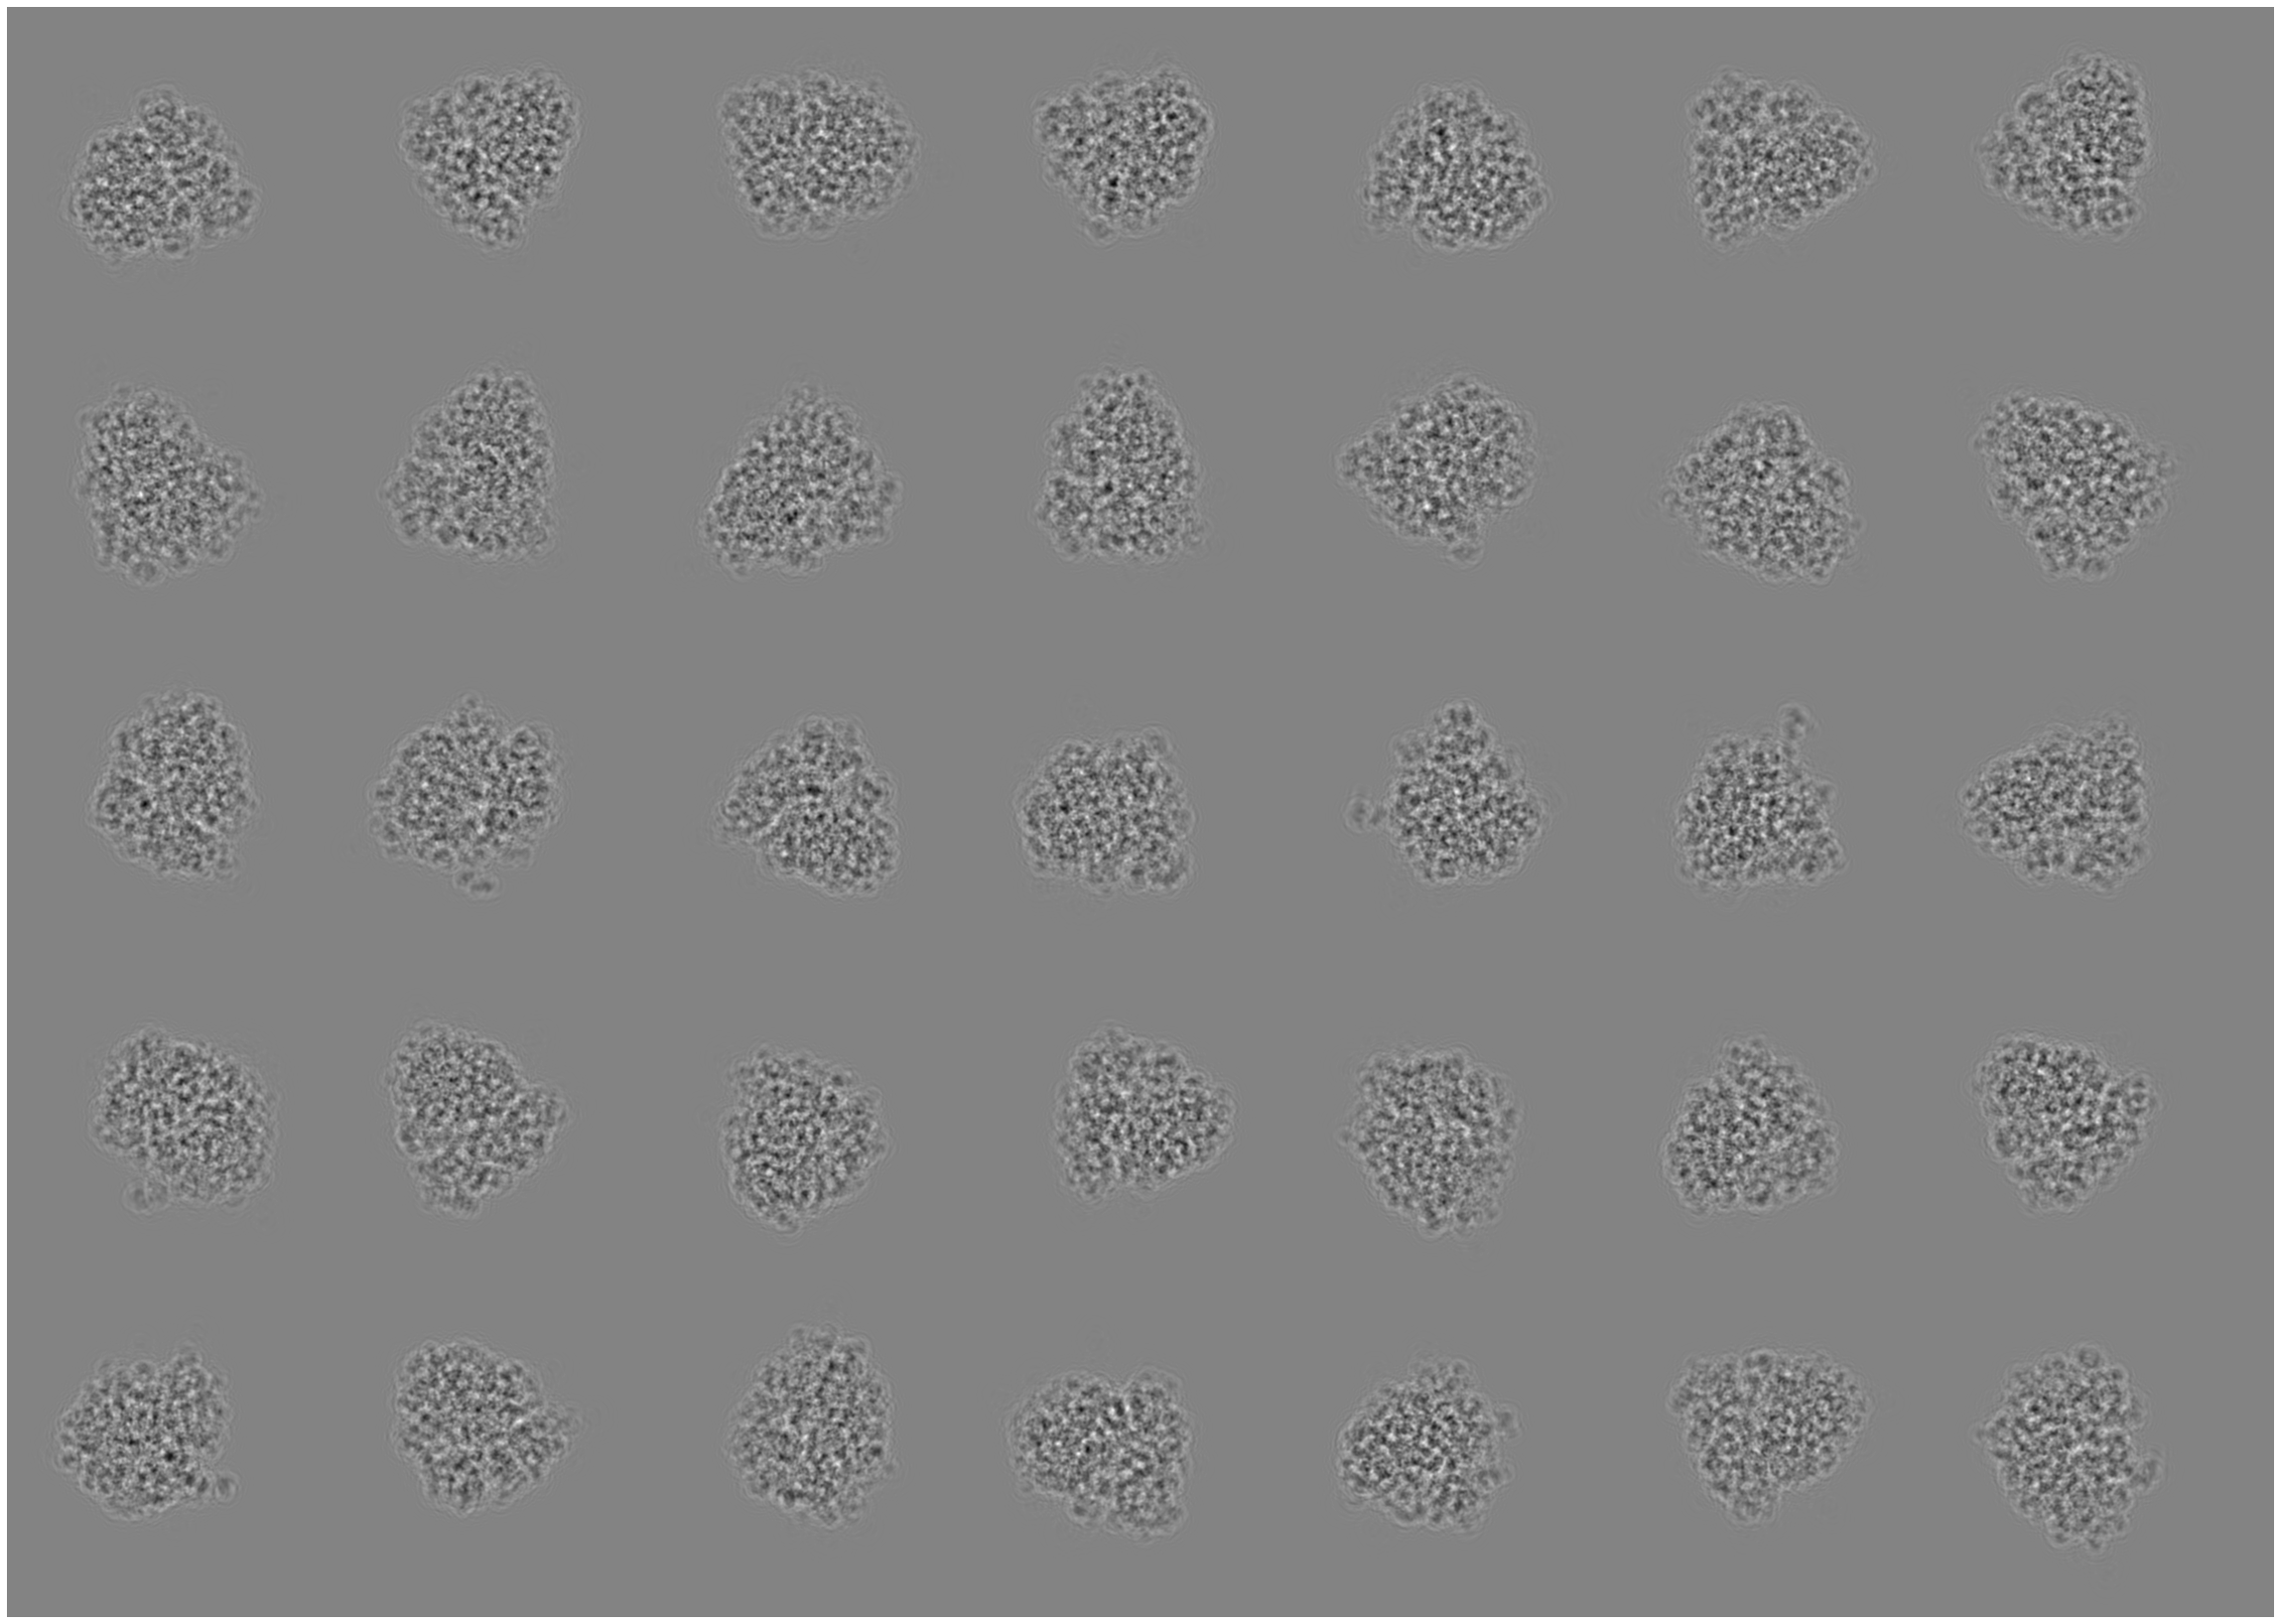

In [4]:
#Plot the original micrograph
plot_image(micrograph, 0.01)

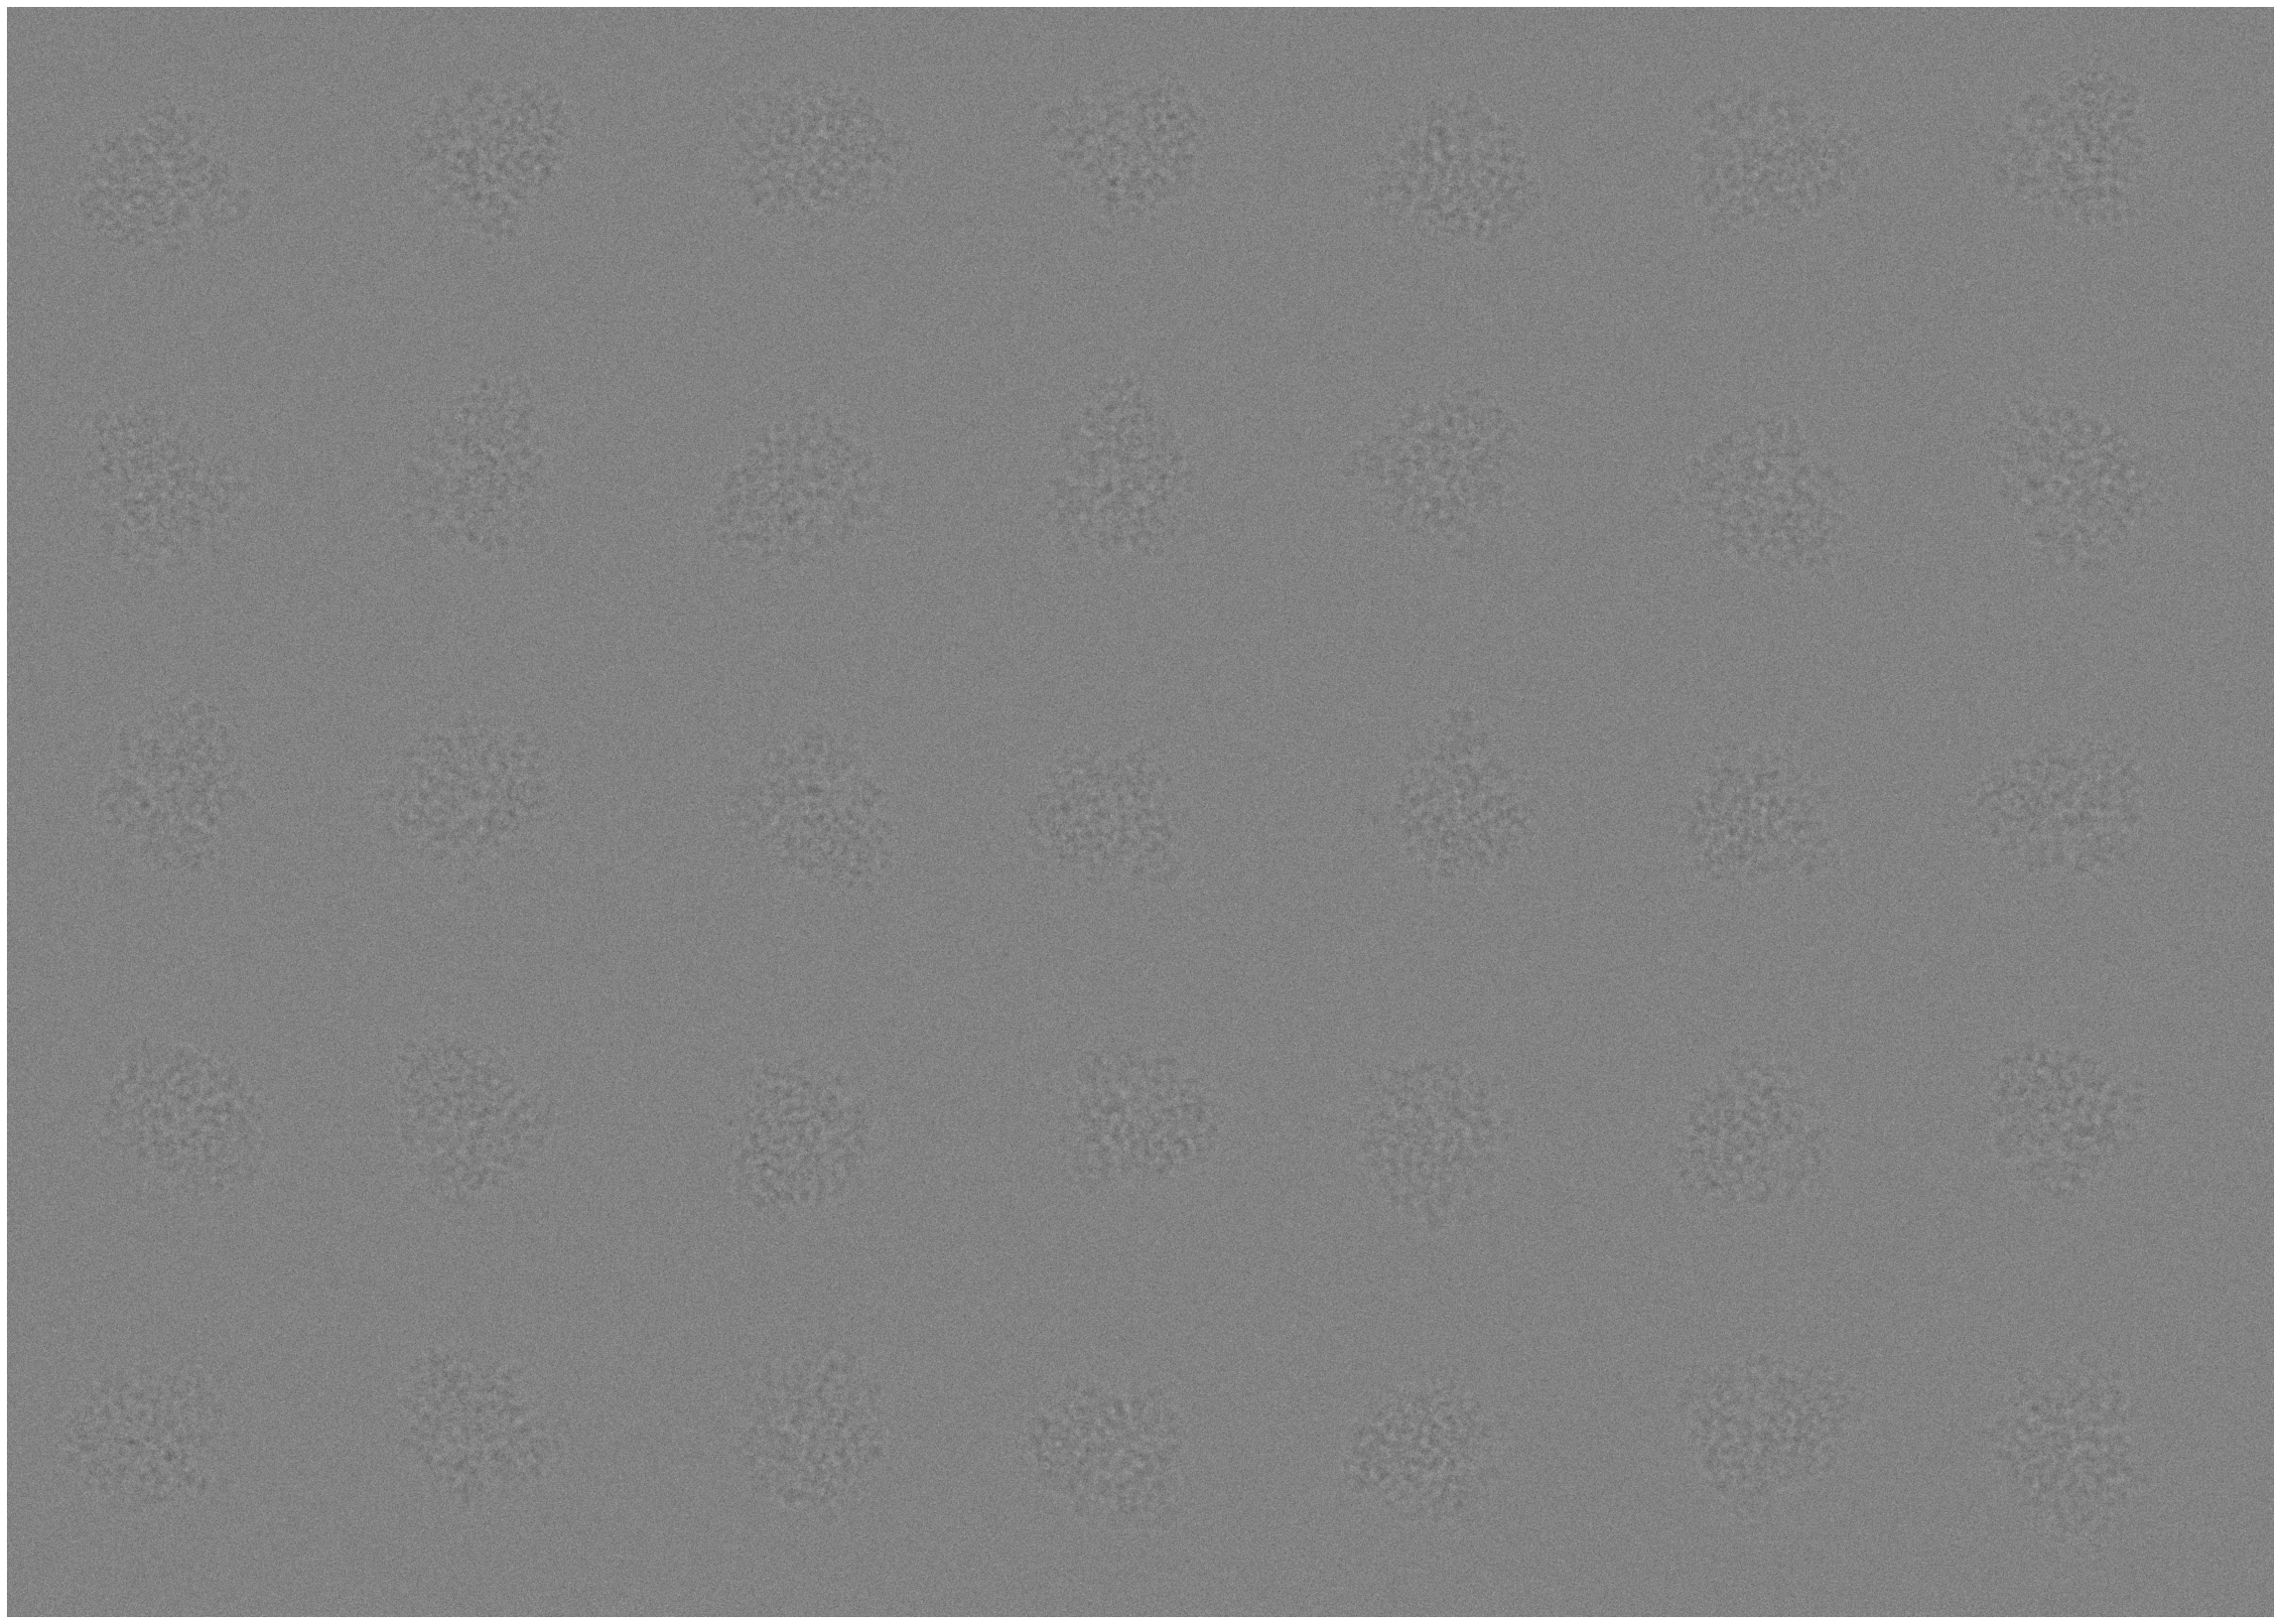

In [5]:
#Plot corrupted micrograph wish gaussian noise
plot_image(micrograph_with_noise, 0.01)

### shift_utils

In [6]:
#Load and normalize image
micrograph_particle_path = 'tests/test_files/micrograph_particle.png'
micrograph_particle = Image.open(micrograph_particle_path).convert('L')
micrograph_particle = np.array(micrograph_particle) / 255.0

In [7]:
plot_image(micrograph_particle, 0.02)

Just two minor comments
- Maybe it is a good idea to either use only dictionaries or only AttrDict objects.
- shift_utils does not use `'batch_size'` passed in `config`.

In [8]:
#Defining shift config and params
shift_config = {'side_len': 256, 'batch_size': 1, 'pixel_size': 3.2}
shift_config = AttrDict(shift_config)
shift_params = {'shift_x':torch.tensor([4]), 'shift_y':torch.tensor([5])}

In [9]:
#Creating shift object
shift = shift_utils.Shift(shift_config)

In [10]:
#Applying shift to ft of particle image
micrograph_particle_ft = fourier.fft2d(micrograph_particle, 'forward')
shifted_fourier_micrograph_particle = shift.forward(torch.tensor(micrograph_particle_ft), shift_params)

## transfer

In [11]:
#Define the parameters for creating a random ctf
n_pixels = 100
pzise = 1
n_particles = 1

#Generate the random ctf
random_ctfs, df1s, df2s, df_ang_deg = transfer.random_ctfs(n_pixels, pzise, n_particles)

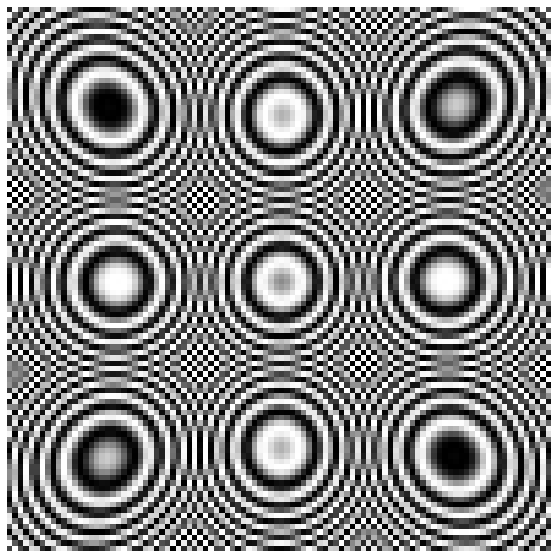

In [12]:
#Plot the random ctf
random_ctfs = random_ctfs.reshape(n_pixels, n_pixels)
plot_image(random_ctfs, 0.1)

In [13]:
#Define the parameters of the ctf
n_pixels = 100
freq_mag_2d, angles_rad = transfer.ctf_freqs(n_pixels, dim=2)
ac = 0.5
ctf = transfer.eval_ctf(
    s=freq_mag_2d,
    a=angles_rad,
    def1=1e4,
    def2=1.1e4,
    angast=0,
    phase=0,
    kv=300,
    ac=ac,
    cs=2.0,
    bf=0,
    lp=0,
)

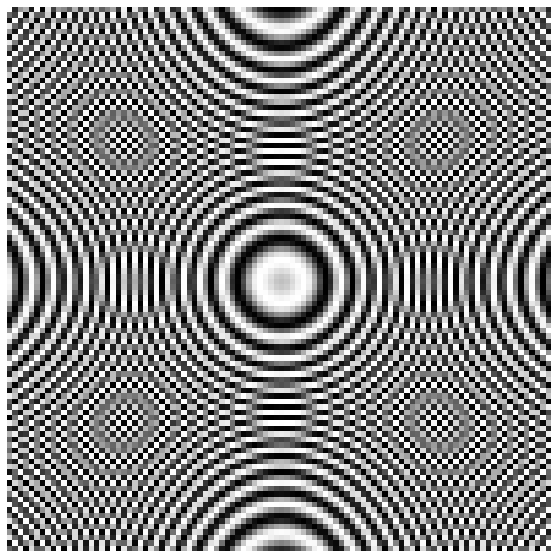

In [14]:
#Display user defined ctf
plot_image(ctf, 0.1)

### multislice

It seems there is a Windows specific problem [1]. The function `apply_poisson_shot_noise_sample` calls `np.random.poisson`, which raises an error due to the high value of the lam parameter on Windows. Decreasing the value of the variable `high_dose`, from  `1e9 * exit_wave.max()` to `1e6 * exit_wave.max()` makes it work out. But this decrease the original value of `high_dose` too much. I have not found a solution for this problem yet.

[1] https://github.com/astronomyk/SimCADO/issues/59

In [15]:
n_pixels = 64
sphere = raster_geometry.sphere(
    [n_pixels, n_pixels, n_pixels], radius=n_pixels // 8, position=0.25
).astype(np.float32)
ones = np.ones((n_pixels, n_pixels))
exit_wave = sphere.sum(-1)
exit_wave_f = fourier.do_fft(exit_wave, dim=2)
high_dose = 1e6 * exit_wave.max()

i, shot_noise_sample, i0_dqe, i0 = multislice.exit_wave_to_image(
    exit_wave_f=exit_wave_f,
    complex_ctf=ones,
    dose=high_dose,
    noise_bg=0,
    dqe=ones,
    ntf=ones,
)

In [16]:
plot_image(i, 0.1)